#ชื่อ-นามสกุล
ณัชชา วัฒนบำเพ็ญ 6509611676

ณัชชา สุขะเมือง 6509611684

ณัชชา หาสิตะพันธ์ุ 6509611692

ภัคสิตานัน กรองทอง 6509611932


# Problem Framing

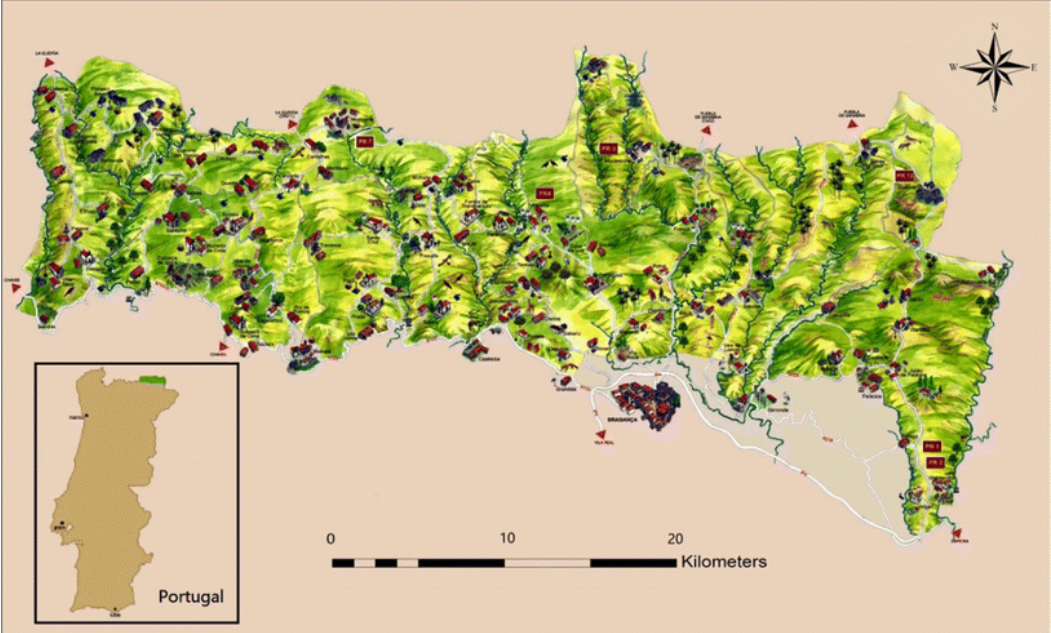


**problem:** การเกิดไฟป่าเป็นปรากฏการณ์ที่พบได้ในพื้นที่ทั่วโลกทั้งในป่า เขตร้อนและป่าเขตเยาว์ โดยทางเราจะทำการ analysis เจาะจงพื้นที่เป็น park แห่งนึงทางภาคตะวันออกเฉียงเหนือของประเทศโปรตุเกส

**วัตถุประสงค์:** เพื่อดูแนวโน้มว่าเดือนไหนมีโอกาสเกิดไฟป่ามากที่สุด และทำนายตำแหน่งสถานที่ที่มีความเสี่ยงที่จะเกิดไฟป่ามากที่สุด เพื่อที่จะสามารถใช้มาตรการที่จะลดการเกิดความเสียหายจากไฟป่า



# Data Acquisition : Secondary Data Collection

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_forest= pd.read_csv('/content/drive/MyDrive/forestfires.csv') #Forest Fires data
df_forest


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [ ]:
# ดูขนาดของ Dataframe (rows, columns)
shape = df_forest.shape

# พิมพ์จำนวนแถวและคอลัมน์
print(f'จำนวน(แถว,คอลลัม): {shape}')


จำนวน(แถว,คอลลัม): (517, 13)


ชุดข้อมูลนี้ประกอบด้วยเหตุการณ์ไฟป่าทั้งหมด 517 ครั้งจากป่า Montesinho natural ในประเทศโปรตุเกส โดยบันทึกข้อมูลวันธรรมดา (weekday), เดือน (month), พิกัด (coordinates), และพื้นที่ที่ไหม้ในทุกเหตุการณ์ รวมถึงข้อมูลอุณหภูมิ, ความชื้น, และแรงลม

กระบวนการทำงานนี้มีการอ่านข้อมูลและฝึกโมเดลการทำนาย (regression model) โดยใช้ตัวแปรทางพื้นที่, เวลา, และสภาพอากาศ

# Data Preparation

เนื่องจากข้อมูลที่เรากำลังศึกษา สามารถเกิดการซ้ำของข้อมูลได้ (เนื่องจากในพื้นที่ใด ๆ มีโอกาสการเกิดไฟป่าได้มากกว่า 1 ครั้ง)   ดังนั้นจึงเหลือกระบวนการวิธี Data Preparation ได้เพียง EDA, Handle Missing Data, Inconsistent Datatypes และ Handle Outliers

In [ ]:
df_forest.columns #พิมพ์ชื่อทั้งหมดทั้ง columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

# Handle Missing Data

In [ ]:
print(df_forest.isnull().sum()) #หาค่า missing data แล้วสั่ง print show มันออกมา

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


สามารถสรุปได้ว่าข้อมูลชุดนี้ ไม่มี missing data

# Handle Outliers

<Axes: >

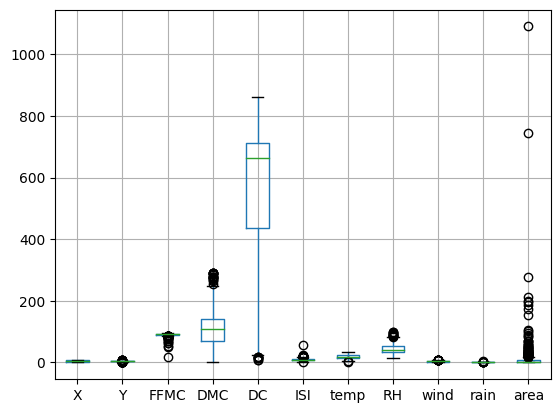

In [ ]:
df_forest.boxplot()# plot เพื่อแสดงให้เห็นว่ามี outliers หรือไม่

จากผลของ boxplot แสดงให้เห็นว่ามี outliers

In [ ]:
def cap_data(df): #สร้างฟังก์ชั่นเพื่อกำจัด outliers
    for col in df.columns: #ใช้ลูปเพื่อลบ outliers ในทุก ๆ คอลลัมน์
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='float64')):
            percentiles = df[col].quantile([0.25,0.75]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

In [ ]:
final_df=cap_data(df_forest) #use function

<ipython-input-9-524e3d2c24bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
<ipython-input-9-524e3d2c24bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] >= percentiles[1]] = percentiles[1]
<ipython-input-9-524e3d2c24bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
<ipython-input-9-524e3d2c24bb>:6: SettingWi

<Axes: >

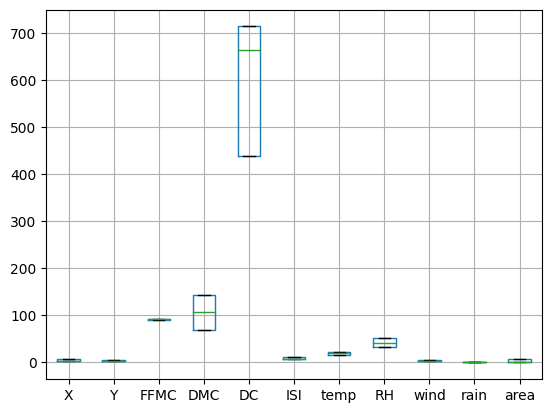

In [ ]:
final_df.boxplot() # boxplot เพื่อแสดงให้เห็นว่ากำจัด outliers ไปแล้ว

# Statistic Analysis

# mean

In [ ]:
print(final_df.mean()) #หาค่า mean ละสั่งให้แสดงออกมา

X         4.827853
Y         4.398453
FFMC     91.587041
DMC     107.123985
DC      606.977369
ISI       8.530948
temp     19.194584
RH       42.344294
wind      3.830561
rain      0.000000
area      2.377621
dtype: float64


<ipython-input-12-cdc2bd7b8ce4>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(final_df.mean()) #หาค่า mean ละสั่งให้แสดงออกมา


 # median

In [ ]:
print(final_df.median())  #หาค่า median ละสั่งให้แสดงออกมา

X         4.00
Y         4.00
FFMC     91.60
DMC     108.30
DC      664.20
ISI       8.40
temp     19.30
RH       42.00
wind      4.00
rain      0.00
area      0.52
dtype: float64


<ipython-input-13-ce380f6c600a>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(final_df.median())  #หาค่า median ละสั่งให้แสดงออกมา


# mode

In [ ]:
print(final_df.mode())   #หาค่า mode ละสั่งให้แสดงออกมา

     X    Y month  day  FFMC    DMC     DC  ISI  temp    RH  wind  rain  area
0  3.0  4.0   aug  sun  90.2   68.6  713.9  6.5  22.8  33.0   4.9   0.0   0.0
1  NaN  NaN   NaN  NaN  92.9  142.4    NaN  NaN   NaN   NaN   NaN   NaN   NaN


#Skewness

In [ ]:
final_df.skew(axis = 0, skipna = True) #หาค่า ความเบ้ของการแจกแจงปกติ ละสั่งให้แสดงออกมา

<ipython-input-15-b96e98fd3084>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  final_df.skew(axis = 0, skipna = True) #หาค่า ความเบ้ของการแจกแจงปกติ ละสั่งให้แสดงออกมา


X       0.167527
Y       0.416043
FFMC   -0.086535
DMC    -0.098251
DC     -0.614589
ISI     0.151909
temp   -0.036581
RH      0.166517
wind   -0.044689
rain    0.000000
area    0.613111
dtype: float64

#Kurtosis

In [ ]:
final_df.kurtosis() #หาค่า ความโด่งของการแจกแจงปกติ ละสั่งให้แสดงออกมา

<ipython-input-16-cc69c351f13c>:1: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  final_df.kurtosis() #หาค่า ความโด่งของการแจกแจงปกติ ละสั่งให้แสดงออกมา


X      -1.648392
Y      -1.834018
FFMC   -1.538004
DMC    -1.583483
DC     -1.346056
ISI    -1.585421
temp   -1.598462
RH     -1.599180
wind   -1.711915
rain    0.000000
area   -1.430224
dtype: float64

#Data Interpretation



จากการวิเคราะห์ข้อมูลเชิงสถิติ (mean, median, mode, skewness, และ kurtosis) สามารถวิเคราะห์ได้ดังนี้

1.   พิกัดตำแหน่ง (x, y) ของตำแหน่งที่เกิดไฟป่าค่อนข้างมีความกระจายตัว และพิกัดที่เกิดไฟป่าบ่อยที่สุดได้แก่ พิกัด (3, 4)
2.   FFMC หรือ ค่าดัชนีการติดไฟ (Fire Fuel Moisture Code) มีค่า mean, median และ mode สูงมาก มีความเบ้ (skewness) ปกติ และมีความโด่งแบน (kurtosis) ต่ำ จึงแสดงว่าพื้นที่เหล่านี้ถือเป็นบริเวณที่ติดไฟง่ายโดยเสมอกัน
3. DMC หรือ ค่าเฉลี่ยความชื้นของเชื้อเพลิงชั้นบางกลาง (Duff Moisture Code) มีค่า mean, median อยู่ระดับปานกลาง ค่า mode มี 2 ค่าได้แก่ 68.6 และ 142.4 มีความเบ้ (skewness) ปกติ และมีความโด่งแบน (kurtosis) ต่ำ  จึงถือว่าพื้นที่เหล่านี้มีค่า DMC ระดับปานกลาง
4. DC หรือ ค่าความชื้นของเชื้อเพลิงชั้นล่างสุด (Drought Cod) มีค่า mean, median และ mode ค่อนข้างสูง มีความเบ้และความโด่งแบนต่ำ (skewness และ kurtosis) จึงถือว่าพื้นที่เหล่านี้มีค่า DC ค่อนข้างสูง
5. ISI หรือ ค่าการลุกลามของไฟ (Initial Spread Index) มีค่า mean, median และ mode ต่ำมาก มีความเบ้ (skewness) ปกติ และมีความโด่งแบน (kurtosis) ต่ำ จึงถึอว่าพื้นที่นี้มีการลุกลามของไฟต่ำ
6. temp หรือ อุณหภูมิ (temperature) มีค่า mean, median และ mode ค่อนข้างต่ำ มีความเบ้ (skewness) ปกติ และมีความโด่งแบน (kurtosis) ต่ำ  จึงแสดงว่าเป็นพื้นที่ที่มีอุณหภูมิค่อนข้างต่ำ
7. RH หรือ ค่าความชื้นสัมพัทธ์ (Relative Humidity) มีค่า mean, median และ mode ค่อนข้างต่ำ และมีความเบ้ (skewness) ปกติ และมีความโด่งแบน (kurtosis) ต่ำ จึงถือว่าเป็นพื้นที่ที่มีค่า RH ค่อนข้างต่ำ
8. wind หรือ แรงลม มีค่า mean, median และ mode ปานกลาง มีความเบ้ (skewness) ปกติ และมีความโด่งแบน (kurtosis) ต่ำ จึงแสดงว่าพื้นที่ที่เกิดไฟป่ามีแรงลมปานกลาง
9. rain หรือปริมาณฝน จากสถิติได้ว่าทั้งค่า mean, median, mode, skewness, และ kurtosis มีค่าเป็น 0 ทั้งหมด แสดงว่าขณะที่เกิดไฟป่านั้น ไม่มีฝนตกเลย
10. area หรือ อาณาเขตที่เกิดไฟป่า มีค่า mean, median, และ mode น้อย มีความเบ้และความโด่งแบนต่ำ (skewness และ kurtosis) แสดงให้เห็นถึงพื้นที่ที่เกิดไฟป่านั้น มีลักษณะเป็นหย่อมขนาดเล็ก ไม่ลุกลามเป็นวงกว้าง
11. เดือนสิงหาคม (august) เป็นเดือนที่เกิดไฟป่ามากที่สุด
12. วันอาทิตย์ (sunday) เป็นวันที่เกิดไฟป่ามากที่สุด



#Data Visualization

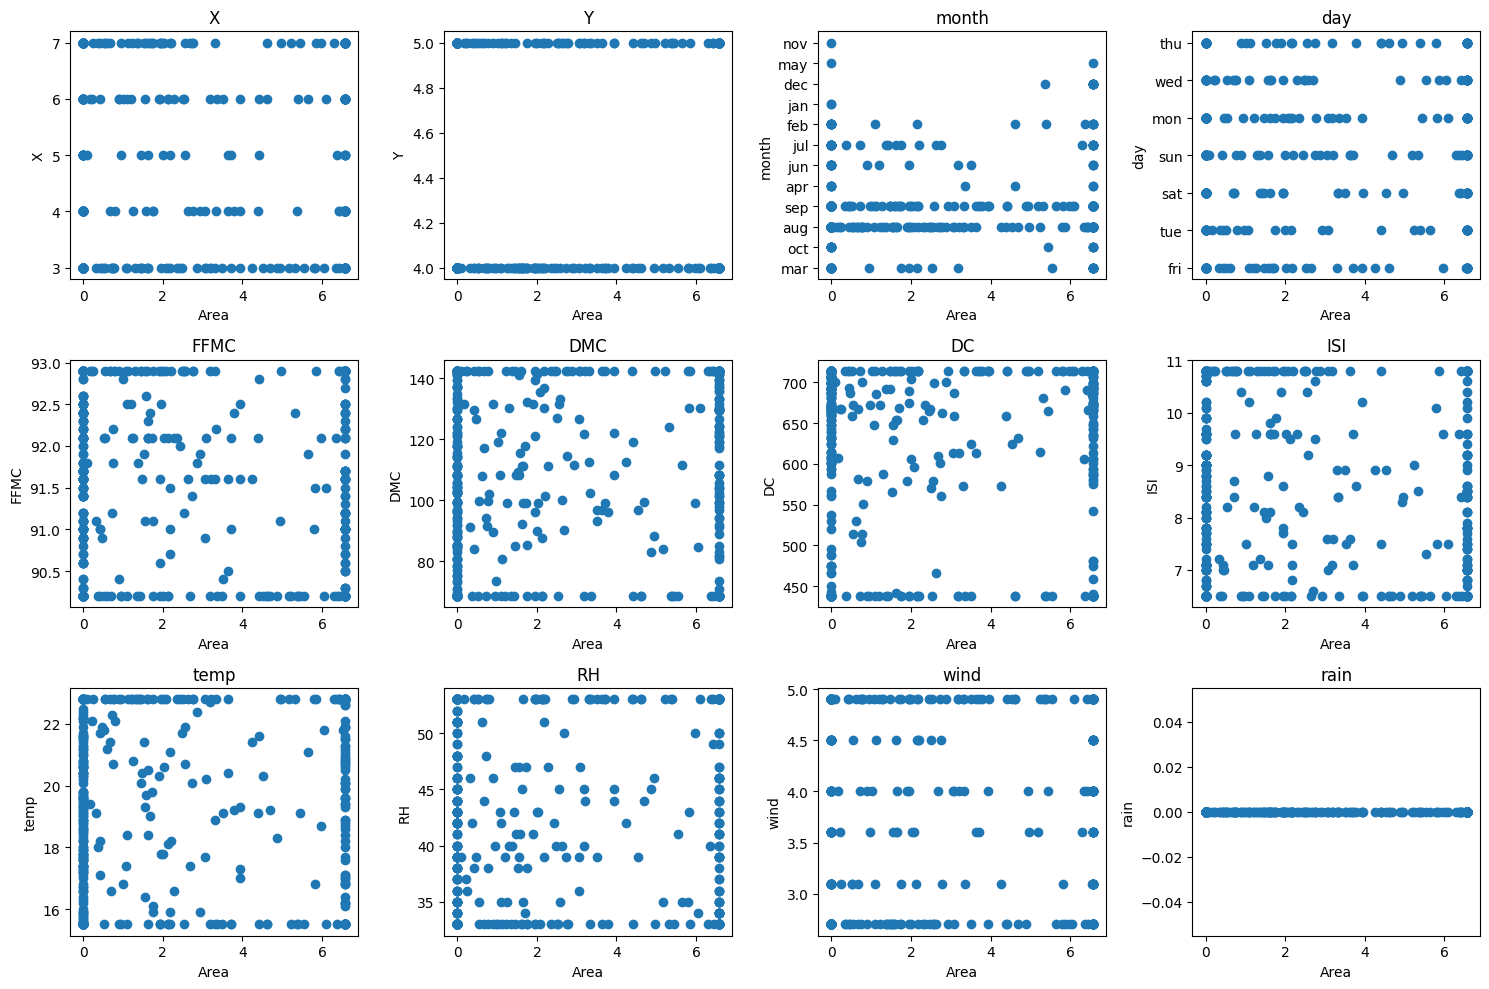

In [ ]:
#plot ระหว่าง area กับคอลัมน์อื่นทั้งหมด
#สร้างตัวแปลเก็บค่าคอลัมน์
area = final_df['area']

#สร้างกราฟและกำหนดขนาดของรูป
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

#ทำให้เข้าถึงแผนภาพง่ายขึ้น
axs = axs.flatten()

#วนลูปผ่านทุกคอลัมน์ (ยกเว้น 'area') และพล็อตกราฟระหว่างคอลัมน์นั้นกับ 'area'
for i, column in enumerate(final_df.columns[:-1]):
    axs[i].scatter(area, df_forest[column])
    axs[i].set_title(column)
    axs[i].set_xlabel('Area')
    axs[i].set_ylabel(column)

#จัดหน้าตากราฟให้เหมาะสมและแสดงกราฟทั้งหมด
plt.tight_layout()
plt.show()

# EDA

In [ ]:
final_df.info() #เพื่อแสดงข้อมูลเกี่ยวกับ Forest Fires data  ทั้งหมดเพื่อให้ผู้ใช้ทราบถึงรายละเอียดต่าง ๆ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [ ]:
final_df.describe() #ดึงข้อมูลสถิติทางทฤษฎีบนคอลัมน์ของ Forest Fires data ละสั่งให้แสดงผลออกมา

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.0,517.000000
mean,4.827853,4.398453,91.587041,107.123985,606.977369,8.530948,19.194584,42.344294,3.830561,0.0,2.377621
std,1.648160,0.490054,1.064748,29.546361,112.712869,1.725776,2.924583,8.153888,0.934831,0.0,2.834060
min,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.0,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.0,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.0,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.0,6.570000
max,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.0,6.570000


#Classification

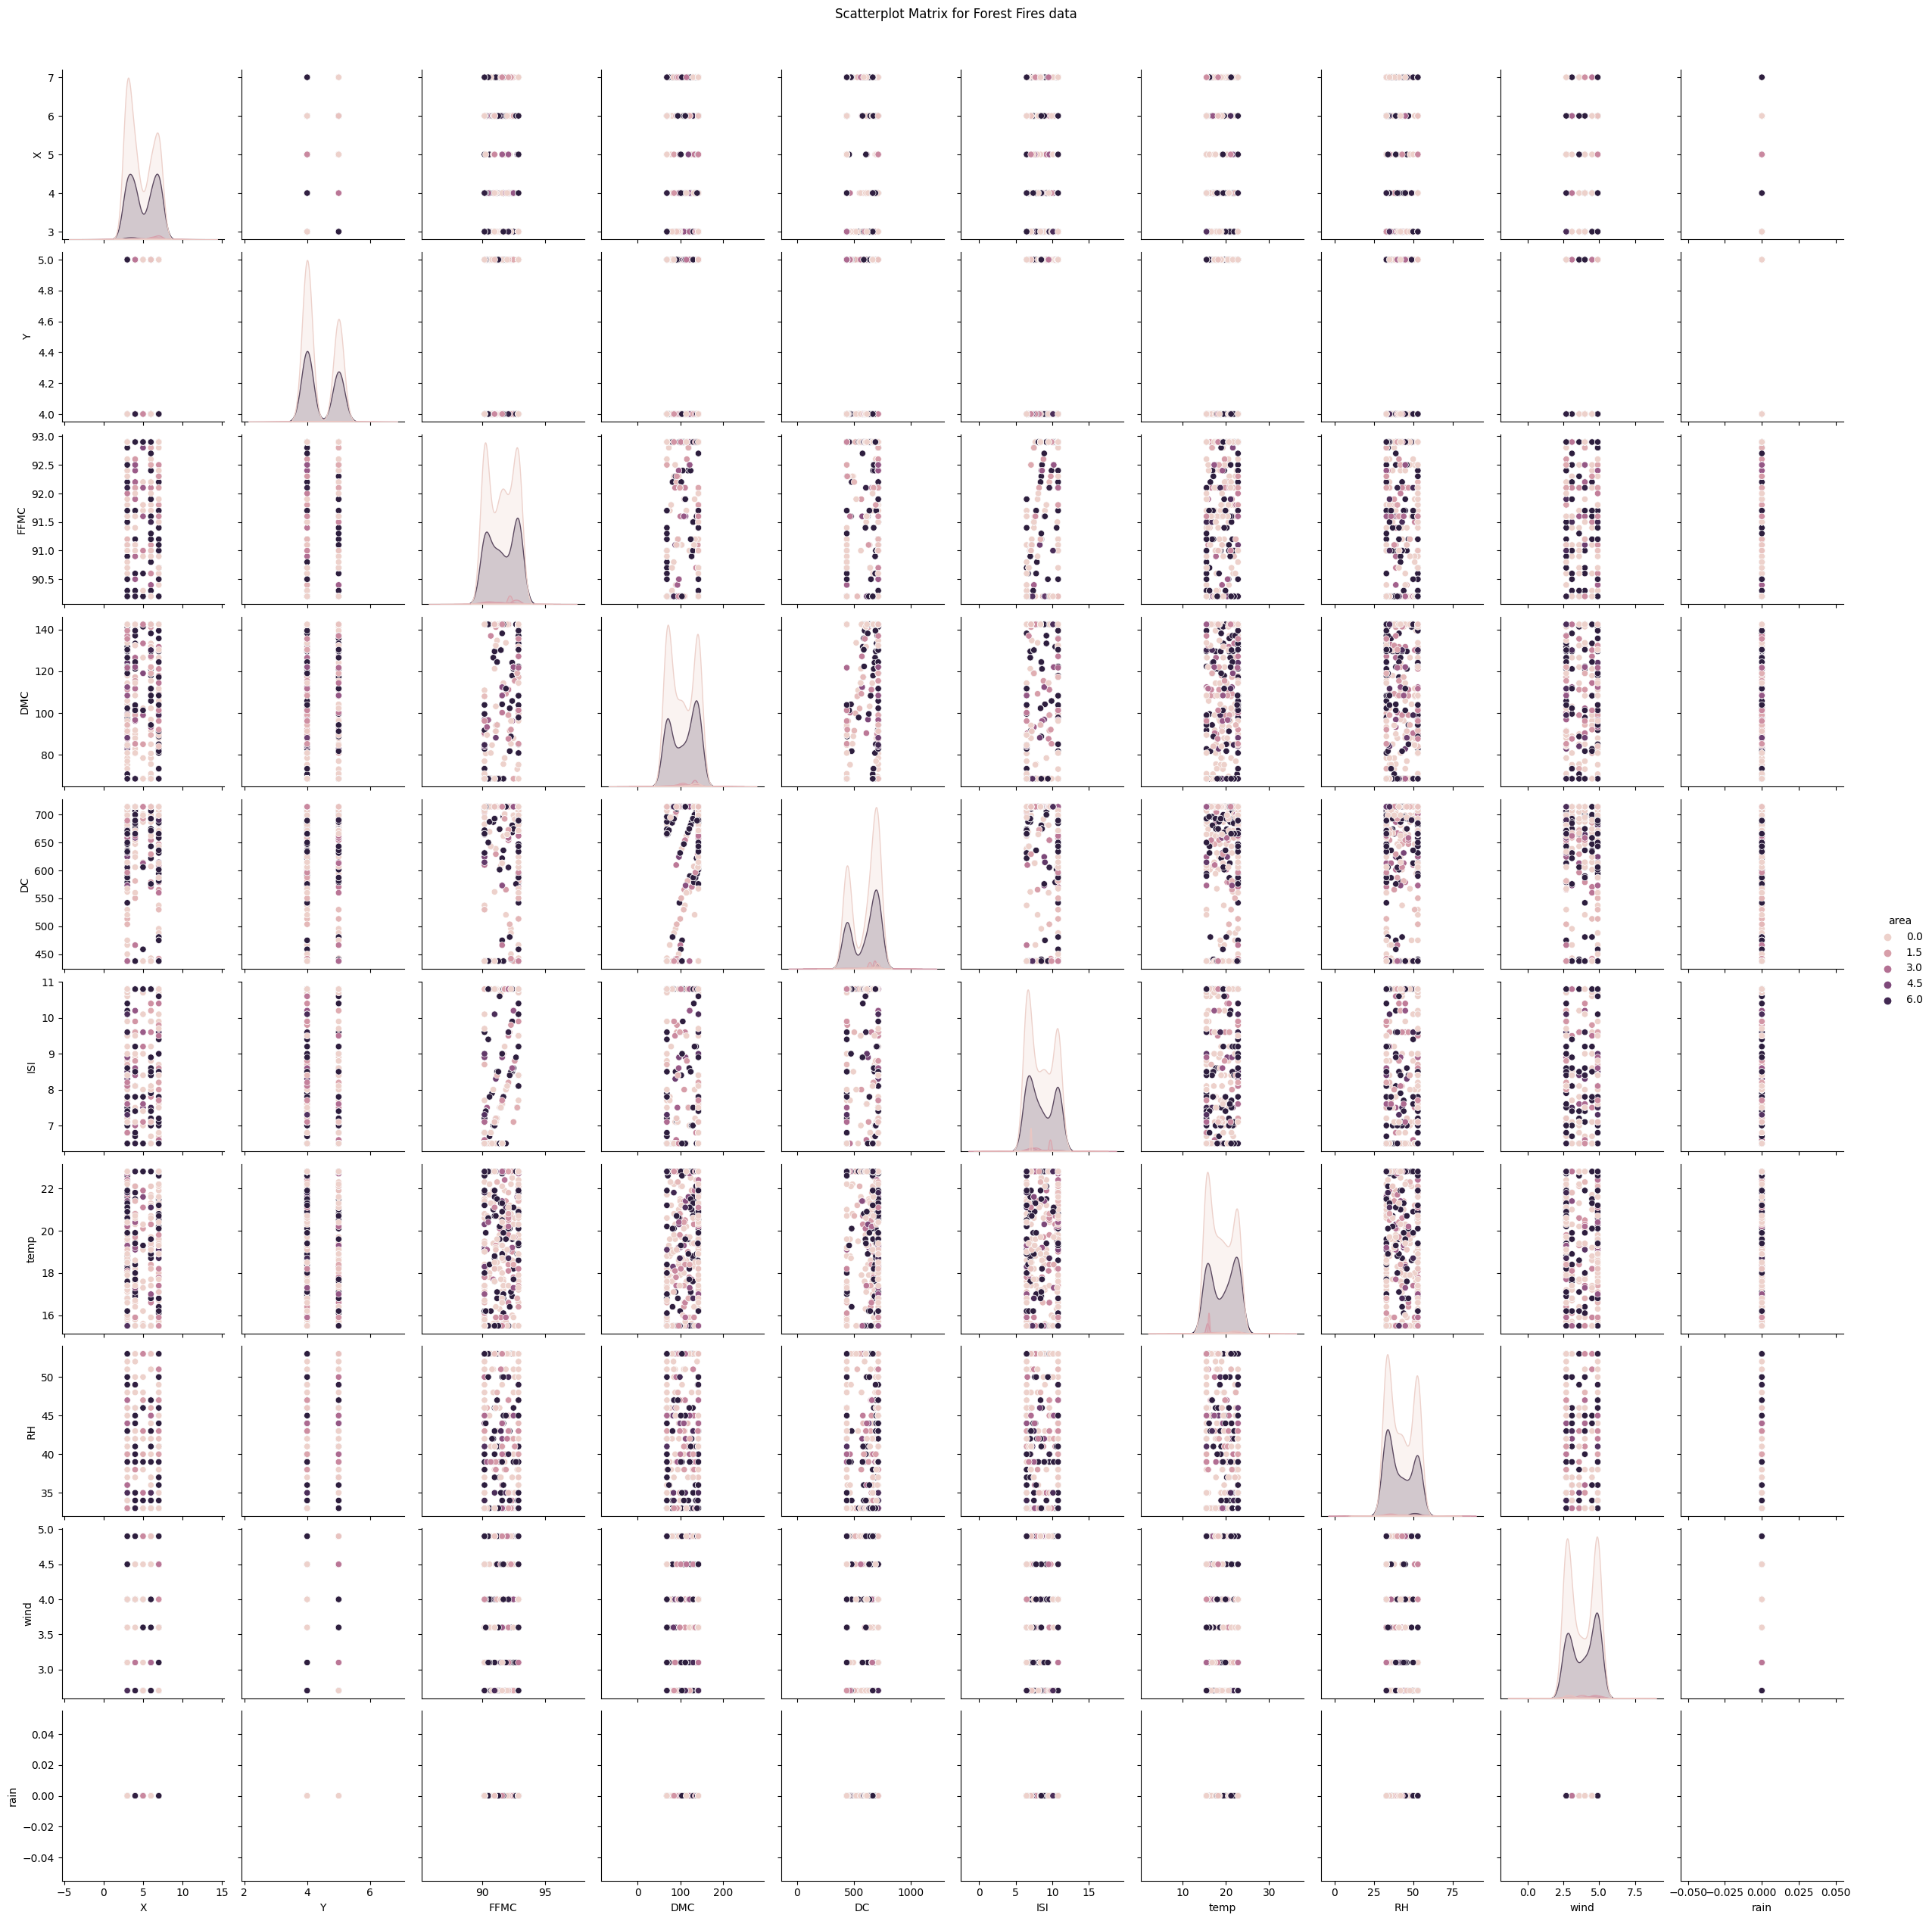

In [ ]:
X = final_df.drop('area', axis = 1) # ประกาศตัวแปร X เป็นข้อมูล dataset ที่ drop column 'area' ออก
Y = final_df['area'] # ประกาศตัวแปร Y เป็นข้อมูล column 'area'
sns.pairplot(final_df, hue='area') # สร้าง pairplot เพื่อ visualize ความสัมพันธ์ระหว่าง final_df
plt.suptitle('Scatterplot Matrix for Forest Fires data', y = 1.02) # เพิ่มหัวข้อของ pairplot
plt.show() # แสดง pairplot

#การPredictตำแหน่งที่จะเกิดไฟป่า

In [ ]:
#predict ตำแหน่งที่จะเกิดไฟป่า
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# เลือก features (X) และ target variable (y)
X = df_forest[['X', 'Y']]
y = df_forest['area']

# แบ่งข้อมูลเป็นชุดการฝึกอบรมและการทดสอบ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างและฝึกอบรมโมเดล Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# ใช้โมเดลที่ฝึกอบรมไว้กับข้อมูลที่มีอยู่
prediction_all_data = model.predict(X)

# แสดงผลลัพธ์ที่ทำนาย
print(f"The predicted areas for all locations are: {prediction_all_data} hectares")

The predicted areas for all locations are: [2.64842203 2.6403336  2.6403336  2.64842203 2.64842203 2.64842203
 2.64842203 2.64842203 2.64842203 2.64842203 2.64842203 2.64842203
 2.53043928 2.53043928 2.53043928 2.53043928 2.41245654 2.64842203
 2.52235085 2.52235085 2.52235085 2.40436811 2.6403336  2.6403336
 2.6403336  2.6403336  2.6403336  2.6403336  2.52235085 2.52235085
 2.52235085 2.52235085 2.52235085 2.52235085 2.52235085 2.52235085
 2.52235085 2.6403336  2.6403336  2.28638536 2.28638536 2.28638536
 2.28638536 2.28638536 2.28638536 2.41245654 2.41245654 2.53043928
 2.28638536 2.28638536 2.28638536 2.28638536 2.28638536 2.28638536
 2.28638536 2.28638536 2.28638536 2.28638536 2.16840262 2.16840262
 2.16840262 2.16840262 2.16840262 2.16840262 2.16840262 2.16840262
 2.16840262 2.16840262 2.16840262 2.29447379 2.29447379 2.29447379
 2.40436811 2.40436811 2.40436811 2.64842203 2.64842203 2.16840262
 2.16840262 2.16840262 2.16840262 2.16840262 2.16840262 2.16840262
 2.16840262 2.168402

In [ ]:
# หาตำแหน่งที่มีความน่าจะเป็นสูงที่สุด
max_index = prediction_all_data.argmax()

# ดึงข้อมูล X, Y ที่มีความน่าจะเป็นสูงที่สุด
max_position = df_forest.iloc[max_index][['X', 'Y']]

# แสดงผลลัพธ์
print(f"The location with the highest predicted area for fire occurrence is at position: {max_position}")

The location with the highest predicted area for fire occurrence is at position: X    7
Y    5
Name: 0, dtype: object


พิกัด X,Y ของตำแหน่งความเป็นไปได้มากที่สุดที่จะเกิดไฟป่า

In [ ]:
#หาค่าที่มากที่สุด
max_prediction = max(prediction_all_data)
print(f"The maximum predicted area for fire occurrence is: {max_prediction} hectares")

The maximum predicted area for fire occurrence is: 2.648422026898338 hectares


พื้นที่ที่โมเดลคาดการณ์ว่ามีโอกาสเกิดไฟป่ามากที่สุดมีขนาดประมาณ 2.65 เฮคตาร์